In [132]:
using Luxor
using Colors
using Plots
using IterTools
using DataFrames
using OpenStreetMapX
using LightOSM
using KernelDensity
using Parsers
using Downloads
using OSMToolset
include("kernel_density.jl")
include("distance.jl")
include("prepare_data.jl")
include("analyse.jl")
include("plots.jl")
include("transform.jl")

matrix_log_scaling (generic function with 1 method)

In [3]:
function calc_tile_road_length(city_parse_data,city_centre)
    road_types = ["motorway", "trunk", "primary", "secondary", 
                "tertiary", "residential", "service", "living_street", 
                "motorway_link", "trunk_link", "primary_link", "secondary_link", 
                "tertiary_link"]
    
    total_length = 0.0
    
    for way in city_parse_data.ways
        if haskey(way.tags, "highway") && (way.tags["highway"] in road_types)
            for i in 1:(length(way.nodes) - 1)
                node1 = ENU(city_parse_data.nodes[way.nodes[i]],city_centre)
                node2 = ENU(city_parse_data.nodes[way.nodes[i + 1]],city_centre)
                total_length += OpenStreetMapX.distance(node1,node2)
            end
        end
    end
    return total_length
end

calc_tile_road_length (generic function with 1 method)

In [4]:
function calc_tile_area(bounds,tile_centre)
    node1 = ENU(bounds,tile_centre)
    return node1.min_x*2*node1.min_y*2
end

calc_tile_area (generic function with 1 method)

In [5]:
"""
y - lat/east
x - lon/north
"""
function rectangle(bounds, centre)
    ENU_coords = ENU(bounds,centre)
    return [ENU_coords.min_y, ENU_coords.min_y,
            ENU_coords.max_y, ENU_coords.max_y],
            [ENU_coords.min_x, ENU_coords.max_x,
            ENU_coords.max_x, ENU_coords.min_x]
end

rectangle

In [6]:
function get_city_bounds(city_name)
    boundaries_file = string(city_name,"_boundaries.osm")
    admin_city_centre = get_city_centre(boundaries_file)
    city_boundaries = extract_points_ENU(boundaries_file,admin_city_centre)
    return city_boundaries, admin_city_centre
end

get_city_bounds (generic function with 2 methods)

In [150]:
outfiles = tile_osm_file("Kielce.osm",nrow=20,ncol=20,out_dir="./tiles")

20×20 Matrix{String}:
 "50.7932894_50.79937906_20.5105231_20.52102834.osm"                 …  "50.7932894_50.79937906_20.71012266_20.7206279.osm"
 "50.79937906_50.80546872_20.5105231_20.52102834.osm"                   "50.79937906_50.80546872_20.71012266_20.7206279.osm"
 "50.80546872_50.81155838_20.5105231_20.52102834.osm"                   "50.80546872_50.81155838_20.71012266_20.7206279.osm"
 "50.81155838_50.81764804_20.5105231_20.52102834.osm"                   "50.81155838_50.81764804_20.71012266_20.7206279.osm"
 "50.81764804_50.823737699999995_20.5105231_20.52102834.osm"            "50.81764804_50.823737699999995_20.71012266_20.7206279.osm"
 "50.823737699999995_50.829827359999996_20.5105231_20.52102834.osm"  …  "50.823737699999995_50.829827359999996_20.71012266_20.7206279.osm"
 "50.829827359999996_50.83591702_20.5105231_20.52102834.osm"            "50.829827359999996_50.83591702_20.71012266_20.7206279.osm"
 "50.83591702_50.84200668_20.5105231_20.52102834.osm"                   "50.

In [151]:
dir = "tiles/"
files = readdir(dir)
bounds = []
lengths = []
areas = []
xs = []
ys = []

Any[]

In [152]:
test_file = joinpath(dir,files[7])
test_file
create_map(test_file;use_cache=false,trim_to_connected_graph=false)

MapData(OpenStreetMapX.Bounds{LLA}(50.7932894, 50.79937906, 20.57355454, 20.58405978), Dict{Int64, ENU}(9967844426 => ENU(209.05008807443474, -31.870658192310778, -0.0034987042187832884), 9959482613 => ENU(-331.4695402260733, 186.0523194547089, -0.011311282055743277), -4268835452490152883 => ENU(-370.31973630181983, 195.26582385519131, -0.013719935857650967), 9967814199 => ENU(90.1637449310328, 16.962209689739183, -0.0006585816424653501), 9967842969 => ENU(-13.188430724213816, 59.42342679520776, -0.00029061130813445857), 4543081995088037610 => ENU(370.34057812063355, -98.1149368015702, -0.011485269195581793), 4442517699388437934 => ENU(-370.31896441608785, 206.13109321253089, -0.014062015294982189), 9959482607 => ENU(-337.47661810543315, 181.34706650956457, -0.011490052760365188), 9967844416 => ENU(256.606659071555, -51.403045081082766, -0.005358817312746567), 9967814170 => ENU(54.756322457317104, 31.512482229004785, -0.00031246820824826216)…), OpenStreetMapX.Way[OpenStreetMapX.Way(108

In [153]:
boundaries, admin_city_centre = get_city_bounds("Kielce")
for elem in files
    file = joinpath(dir,elem)
    city_parse = OpenStreetMapX.parseOSM(file)
    mapp = create_map(file; use_cache = false, trim_to_connected_graph=false)
    city_centre = OpenStreetMapX.center(mapp.bounds)
    push!(bounds,mapp.bounds)
    push!(lengths, calc_tile_road_length(city_parse,city_centre))
    push!(areas, calc_tile_area(mapp.bounds,city_centre))
    x,y = rectangle(mapp.bounds,admin_city_centre)
    push!(xs,x)
    push!(ys,y)    
end

In [154]:
density = lengths./areas
denisty = min_max_scaling(density)

400-element Vector{Float64}:
 0.0
 0.048363933084321506
 0.11254641068563284
 0.0
 0.095388871631647
 0.20678318929879777
 0.13577588569639992
 0.18465662527808888
 0.07387141343247645
 0.13989472656821256
 ⋮
 0.1093758748526054
 0.21252635533030406
 0.0
 0.06843177247190325
 0.05467024183319217
 0.3662009558352881
 0.05972781828140405
 0.036534859167863004
 0.2087735334252082

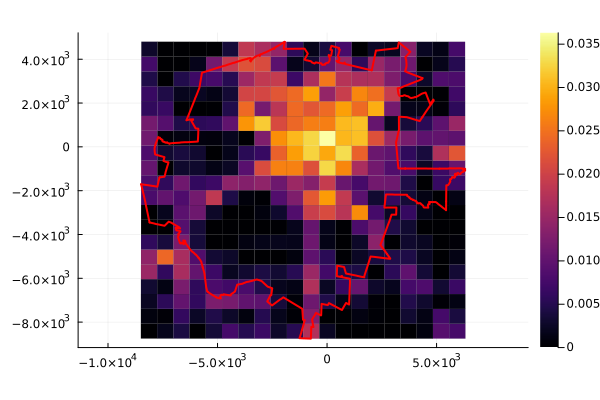

In [162]:
figure = Plots.plot()
grouped_ways = DataFrames.groupby(boundaries, :wayid)

for (y,x,d) in zip(xs,ys,density)
    Plots.plot!(figure, x, y, seriestype = :shape, lw = 0, fillalpha=1,
                aspect_ratio=:equal, legend = false, fill_z=d)
end

for (key, way) in pairs(grouped_ways)
    Plots.plot!(figure, way.x, way.y, label="wayid $(key)", 
                line=:path,legend=false,linecolor=:red,
                                    linewidth=2)
end

figure